<h1 style="text-align:center;">Лабораторная работа №2</h1>

<h3 style="text-align:center;">Осипов Алексей Б01-204</h3>

**Цель**: Решить заданную СЛАУ  следующими методами:

1. Метод Гаусса с выбором главного элемента
2. Метод LU-разложения (если применим)
3. Метод Якоби
4. Метод Зейделя
5. Метод верхней релаксации
6. *Метод градиентного спуска
7. *Метод минимальных невязок
8. *Стабилизированный метод бисопряженных градиентов

Для итерационных методов построить графики значения невязки $r^{(k)} = |Au^{(k)} - f|$ от итерации  
В качестве исходной матрицы я выбрал **вариант к)**

In [32]:
%matplotlib inline

# Подключение библиотек
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

#Вывод чисел
np.set_printoptions(precision=6, suppress=True, formatter={'all': lambda x: f'{x:0.6f}'}) 

In [34]:
# Параметры матрицы А
size = 100

# Точность 
epsilon = 1e-10

# Задание матрицы А и столбца F
A = np.eye(size)

for i in range(size):
    for j in range(size):
        if i!=j:
            A[i, j] = 1/(i+1+j+1)

F = np.zeros((size, 1))
for i in range(size): F[i, 0] = 1/(i+1)
#print('A = ', A)   
#print('F = ', F)

# Вычисление 3й нормы вектора
def norm_3(U):
    r = 0
    for i in range(len(U)):
        r += U[i,0] * U[i,0]
        
    return np.sqrt(r)

In [36]:
# Поменять строки
def swap_rows(A, i, j):
    A[[i, j], :] = A[[j, i], :]

# Поменять столбцы
def swap_columns(A, i, j):
    A[:, [i, j]] = A[:, [j, i]]
    
#Функция для обмена значений
def swap(a,b):
    return b,a
    
# глобальный элемент А
def find_main_el(A, iter):
    size = A.shape[0]
    main_el = A[iter,iter]
    i_main = iter
    j_main = iter

    for i in range(size - iter): 
        for j in range(size - iter):
            if abs(A[i + iter,j + iter]) > abs(main_el):
                i_main = i + iter
                j_main = j + iter
                main_el = A[i_main,j_main]
    return [i_main, j_main]

1) **Метод Гауса с поиском главного элемента: <br>**

Дана СЛАУ в виде $Ax = f$  
Алгоритм состоит из прямого и обратного хода. В прямом ходу матрица приводится к верхнедиагональному виду, причём главный элемент для каждой итерации находится на главной диагонали. Обратный ход сотавляет в матрице главную диагональ, тем самым находя ответ

In [4]:
def Gauss(a, f):
    
    A = copy.deepcopy(a)
    F = copy.deepcopy(f)
    
    size = len(A)  # размеры матрицы 
    
    X = np.arange(size) # Массив, чтобы запомнить порядок при смене строк и столбцов - пригодится в конце
    U  = np.ones((size, 1)) # массив решений
    result = np.ones((size, 1)) # Для ответа

    # Прямой ход
    for iter in range(size): 
        
        main_ind = find_main_el(A,iter) # Rоординаты главного элемента
        main_el = A[main_ind[0], main_ind[1]] # Сам главный элемент
        
        if(main_ind[0] - iter != 0): # Перестановка строк для главного элемента
            swap_rows(A[iter:, iter:], 0, main_ind[0] - iter)
            F[iter] = F[main_ind[0]] + F[iter]
            F[main_ind[0]] = F[iter] - F[main_ind[0]]
            F[iter] = F[iter] - F[main_ind[0]]
            
        if(main_ind[1] - iter != 0): # Перестановка столбцов для главного элемента
            swap_columns(A, iter, main_ind[1])
            # swap(X[iter], X[main_ind[1]])
            X[iter] = X[main_ind[1]] + X[iter]
            X[main_ind[1]] = X[iter] - X[main_ind[1]]
            X[iter] = X[iter] - X[main_ind[1]]
        
        A[iter:, iter:][0] =  A[iter:, iter:][0] / main_el
        F[iter] = F[iter] / main_el
        
        for i in range(size - iter - 1):
            F[iter + i + 1] -= (F[iter]  * A[iter:, iter:][i + 1][0])
            A[iter:, iter:][i + 1] -= (A[iter:, iter:][0] * A[iter:, iter:][i + 1][0])

    # Так как алгоритм не доходит до нижнего углового элемента, делаем его 1
    F[-1] /= A[-1, -1]
    A[size - 1, size - 1] = 1
    
    # Обратный ход
    for i in range(size-1, -1, -1):
        U[i] = F[i]
        for j in range(i + 1, size):
            U[i] -= U[j] * A[i][j]

    for i in range(size):
        result[int(X[i])][0] = U[i][0]

    return result

In [40]:
time_start = time.time()
U = Gauss(A, F)
time_Gauss = time.time() - time_start

2) **Метод LU разложения:**  
Дана СЛАУ в виде $Ax = f$. Её необходимо привести к виду $LUx = f$, где $U$ - верхнедиагональная матрица, а $L$ - нижнедиагональная, причём $LU = A$  
После разложения на $L$ и $U$ нужно сделать замену $Ux = y$, а затем решить $Ly = f$. Затем мы узнаём $y$ и подставляем в $Ux = y$, откуда находим $x$

In [43]:
def LU(a, f):
    
    A = copy.deepcopy(a)
    F = copy.deepcopy(f)
    
    size = len(A)
    
    L = np.zeros((size, size))
    U = np.zeros((size, size))
    
    # Поиск L и U
    for i in range(size):
        for j in range(i, size):
            U[i, j] = A[i, j] - sum(L[i, k] * U[k, j] for k in range(i))
        for j in range(i, size):
            if i == j:
                L[i, i] = 1
            else:
                L[j, i] = (A[j, i] - sum(L[j, k] * U[k, i] for k in range(i))) / U[i, i]

    #Ly = F
    Y = np.ones((size, 1))
            
    for i in range(0, size):
        Y[i] = F[i]
        for j in range(0, i):
            Y[i] -= Y[j] * L[i][j]

    #Ux = Y    
    X  = np.ones((size, 1))

    for i in range(size - 1, -1, -1):
        X[i] = Y[i]
        for j in range(i + 1, size):
            X[i] -= X[j] * U[i][j]
        X[i] /= U[i][i]
        
    return X

In [44]:
time_start = time.time()
U = LU(A, F)
time_LU = time.time() - time_start

3) **Метод Якоби:**  

Дана СЛАУ $Ax = f$. Матрицу $A$ необходимо привести к виду $A = L + D + R$, где $L$ - нижний треугольник матрицы, кроме диагонали, $D$ - главная диагональ, $R$ - верхний треугольник матрицы, кроме диагонали  
Формула для расчёта: $x^{(k + 1)} = -D^{-1}(L + R)x^{(k)} + D^{-1}f$

Итерационный метод заключается в постепенном приближении с некоторого начального $x^{(0)}$, а условием выхода является значение невязки $r$

In [49]:
def Yakobi(a, f, x_0, epsilon):

    A = copy.deepcopy(a)
    F = copy.deepcopy(f)
    
    X_old = copy.deepcopy(x_0)
    X_new = copy.deepcopy(x_0)
    
    size = len(A)
    k = 0
    norms = [] # Для построения графика
    r = norm_3(A @ X_new - F)
    
    while (r > epsilon and k < 1000):
        for i in range(size):
            X_new[i] = 0
            for j in range(0, size):
                if (j != i): X_new[i] = X_new[i] + A[i][j] * X_old[j]
            X_new[i] = (F[i] - X_old[i]) / A[i][i]
        X_old = X_new
        
        k += 1
        r = norm_3(A @ X_new - F)
        norms.append(r)
        
        
    return X_new, k, norms

In [51]:
U_0 = np.ones((size,1))
time_start = time.time()
U, k, norms_Yakobi = Yakobi(A, F, U_0, epsilon)
time_Yakobi = time.time() - time_start

4) **Метод Zейделя:**  

Дана СЛАУ $Ax = f$. Матрицу $A$ необходимо привести к виду $A = L + D + R$, где $L$ - нижний треугольник матрицы, кроме диагонали, $D$ - главная диагональ, $R$ - верхний треугольник матрицы, кроме диагонали  
Формула для расчёта: $x^{(k + 1)} = -(L + R)^{-1}Rx^{(k)} + (L+D)^{-1}f$  
Отличается от метода Якоби формулой

In [53]:
def Zeidel(a, f, x_0, epsilon):
    
    A = copy.deepcopy(a)
    F = copy.deepcopy(f)
    
    X_old = copy.deepcopy(x_0)
    X_new = copy.deepcopy(x_0)
    size = len(A)
    k = 0
    r = norm_3(A @ X_new - F)
    norms = [] 
    
    while(r > epsilon):
        for i in range(size):
            sum1 = 0
            for j in range(i):
                sum1 += A[i, j] * X_new[j]
            sum2 = 0
            for j in range(i + 1, size):
                sum2 += A[i, j] * X_old[j]
            X_new[i] = (F[i] - sum1 - sum2) / A[i, i]

        X_old = X_new.copy()
        r = norm_3(A @ X_new - F)
        k += 1
        norms.append(r)
        
    return X_new, k, norms

In [54]:
U_0 = np.ones((size,1))
time_start = time.time()
U, k, norms_Zeidel = Zeidel(A, F, U_0, epsilon)
time_Zeidel = time.time() - time_start

5) **Метод верхней релаксации (SOR):**  

Дана СЛАУ $Ax = f$. Матрицу $A$ необходимо привести к виду $A = L + D + R$, где $L$ - нижний треугольник матрицы, кроме диагонали, $D$ - главная диагональ, $R$ - верхний треугольник матрицы, кроме диагонали  
Формула для расчёта: $x^{(k + 1)} = -(D + wL)^{-1}((w - 1)D + wR)x^{(k)} + w(D+wL)^{-1}f$, где $w$ - релаксационный параметр  

In [56]:
def SOR(a, f, x_0, epsilon, w):
    
    A = copy.deepcopy(a)
    F = copy.deepcopy(f)
    
    X_old = copy.deepcopy(x_0)
    X_new = copy.deepcopy(x_0)    
    size = len(A)
    k = 0
    r = norm_3(A @ X_new - F)
    norms = []
    
    while(r > epsilon and k < 1000):
        
        for i in range(0, size):
            sigma = 0
            for j in range(0,i):
                sigma += A[i,j] * X_new[j]
            for j in range(i+1, size):
                sigma += A[i,j] * X_old[j]
            sigma = (F[i] - sigma) / A[i,i]
            X_new[i] = X_old[i] + w * (sigma - X_old[i])
        
        X_old = X_new.copy()
        r = norm_3(A @ X_new - F)
        k += 1
        norms.append(r)
        
    return X_new, k, norms

In [59]:
U_0 = np.ones((size,1))
w = 0.5
time_start = time.time()
U, k, norms_SOR = SOR(A, F, U_0, epsilon, w)
time_SOR = time.time() - time_start

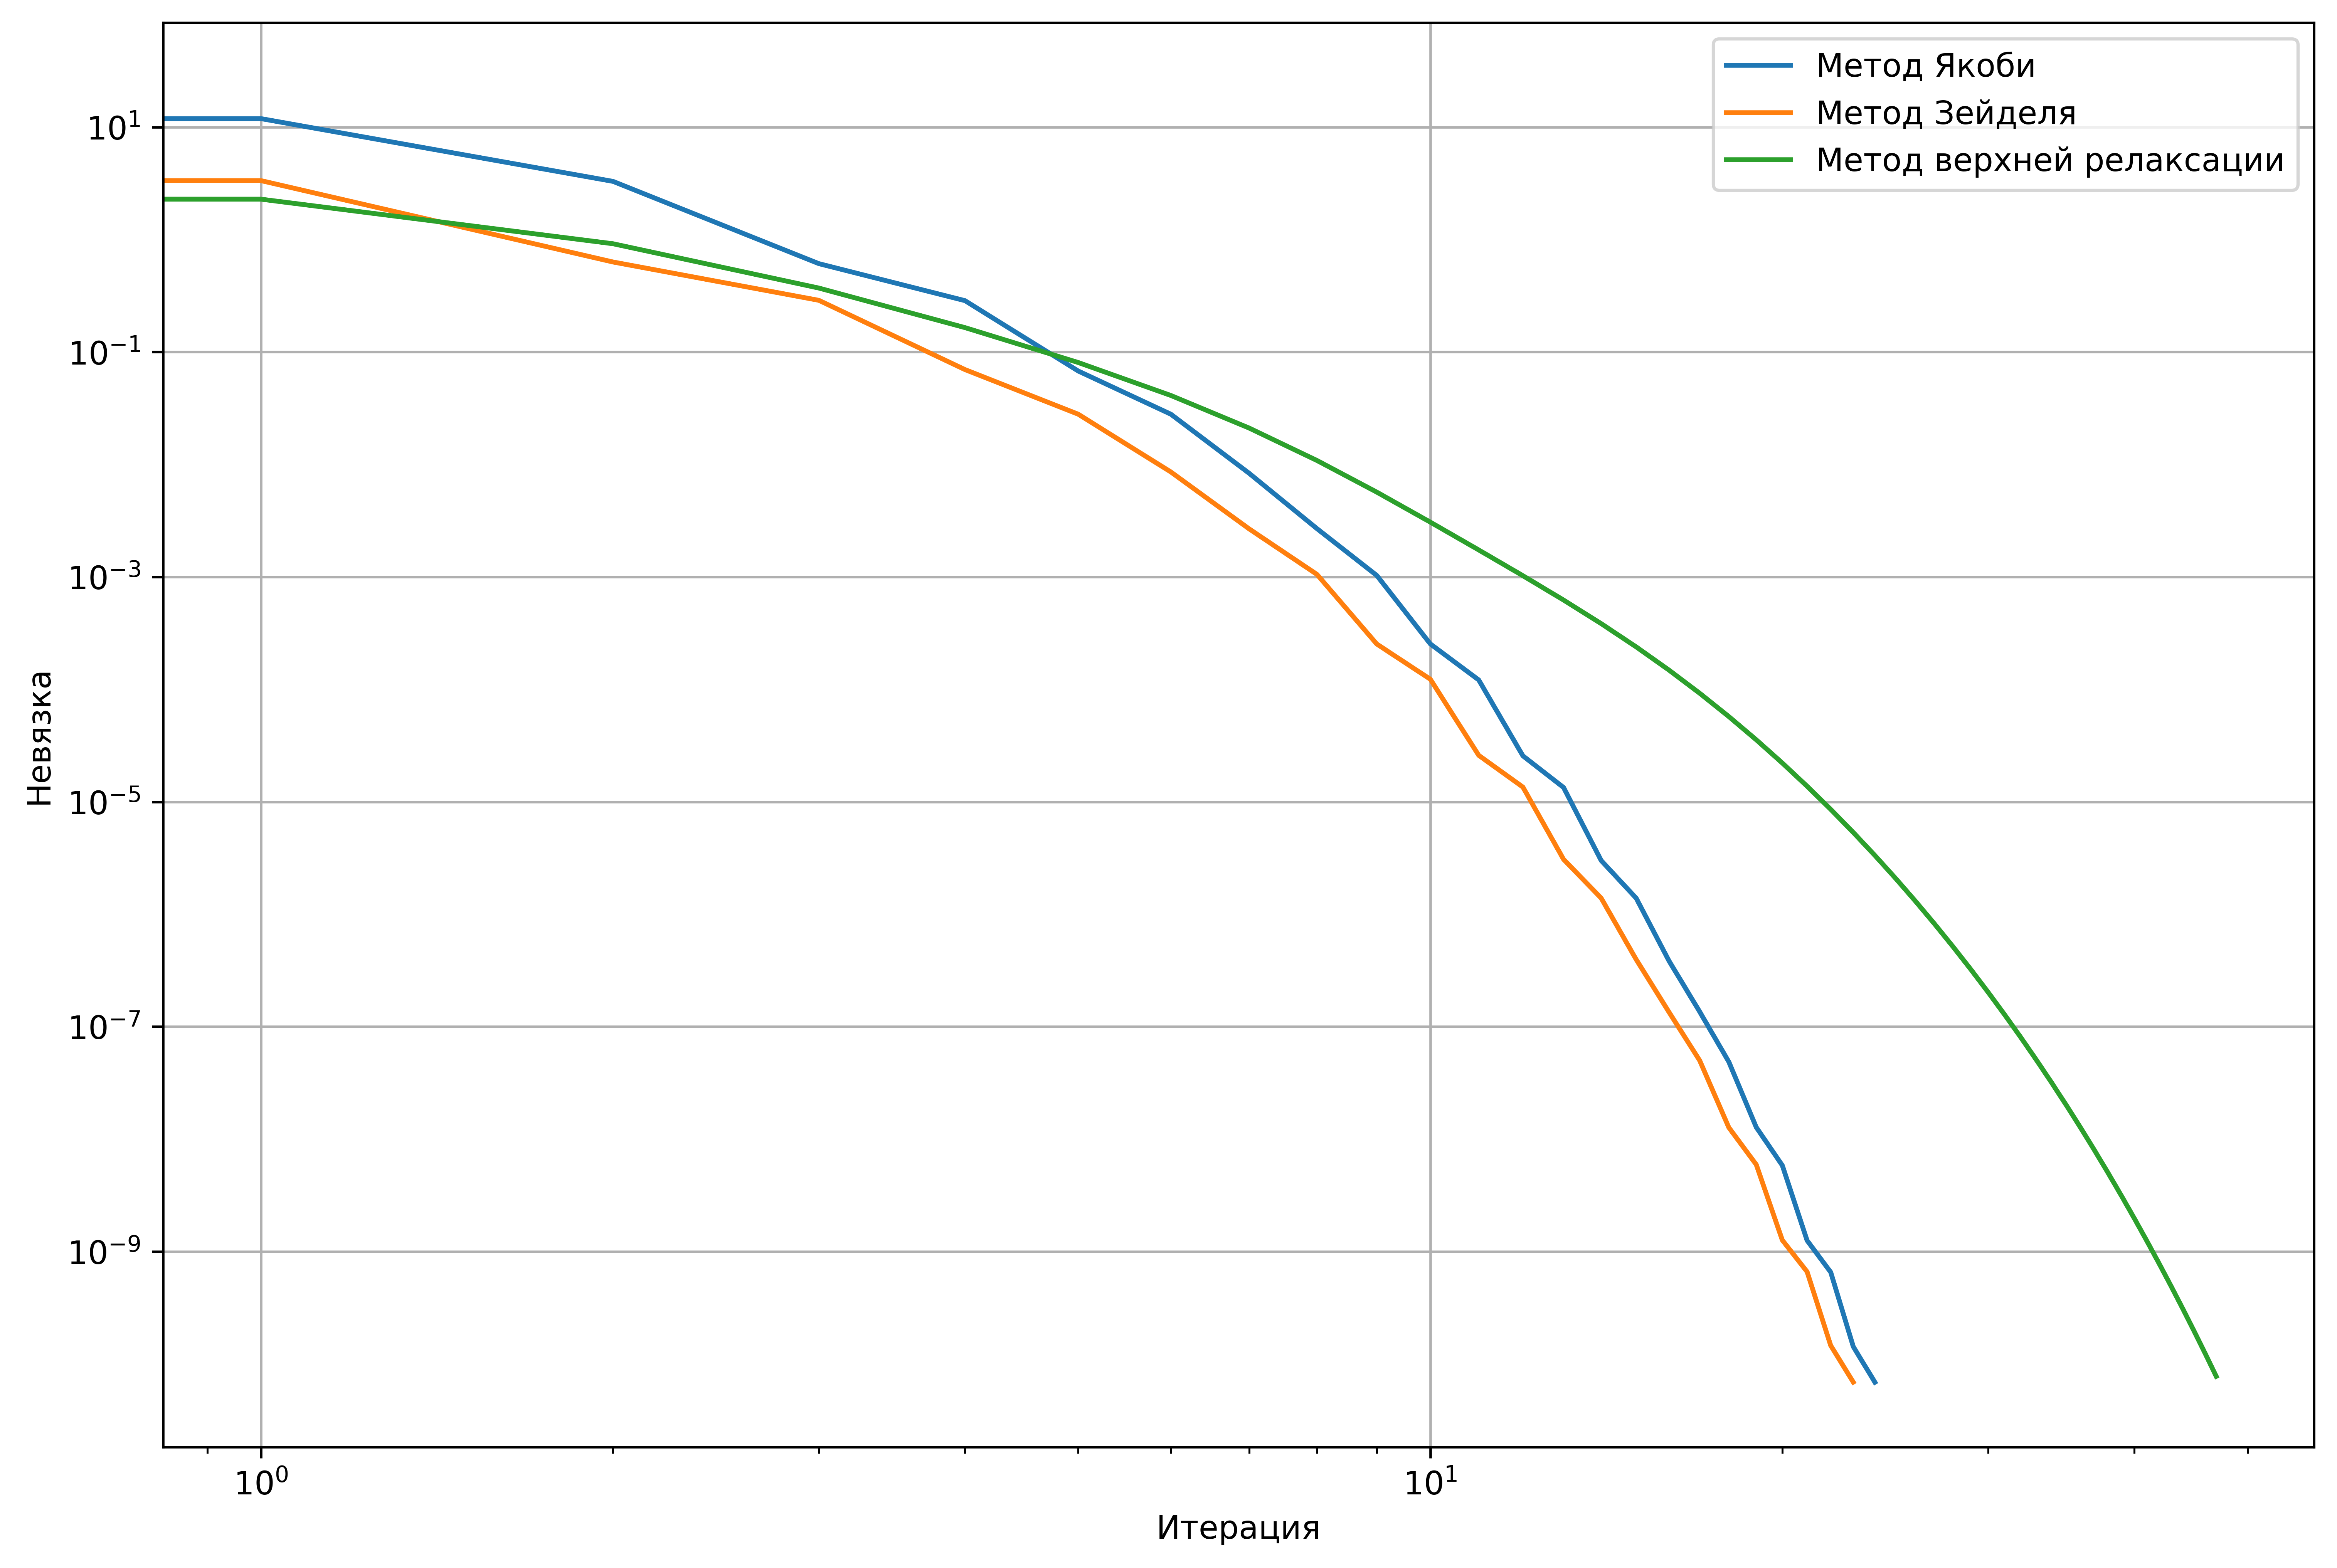

In [62]:
plt.figure(figsize = [12,8], dpi = 600)


plt.plot(np.arange(0, len(norms_Yakobi)), norms_Yakobi, label = "Метод Якоби")
plt.plot(np.arange(0, len(norms_Zeidel)), norms_Zeidel, label = "Метод Зейделя")
plt.plot(np.arange(0, len(norms_SOR)), norms_SOR, label = "Метод верхней релаксации")


plt.xlabel('Итерация')
plt.ylabel('Невязка')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.show()

Сравним время решения для матрицы 100 на 100 (просто для 10 на 10 разница небольшая)

In [65]:
print('Gauss = ', time_Gauss * 1000, 'мс')
print('LU = ', time_LU * 1000, 'мс')
print('Yakobi = ', time_Yakobi * 1000, 'мс')
print('Zeidel = ', time_Zeidel * 1000, 'мс')
print('SOR = ', time_SOR * 1000, 'мс')

Gauss =  122.45988845825195 мс
LU =  132.08913803100586 мс
Yakobi =  526.4794826507568 мс
Zeidel =  492.1257495880127 мс
SOR =  989.1276359558105 мс
